# データの水増し

画像認識精度の向上のためには、あらゆるパターンを想定した画像を用意することが理想である。しかし、それは現実的に困難であるので、代替として手元にある画像から擬似的に別の画像を生成するというアプローチが採られるケースが多い。このアプローチのことを、データの水増し、またはデータ拡張（data augmentation）という。具体的な手法として、画像の反転処理や回転処理などが挙げられる。但し、画像によっては適さない手法がある。例えば、反転処理させると「６」と「９」が、回転処理させると「８」と「∞」が識別できなくなる。

---

TensorFlow等のライブラリをインポートする。

In [1]:
# 一部の処理でNumpyを使用して記述
import numpy as np
# データの水増し用APIを有するライブラリ
import tensorflow as tf
# 擬似乱数を生成するモジュール
import random
# 画像を表示するライブラリ
import matplotlib.pyplot as plt
# 画像をNotebook内に表示させるための指定
%matplotlib inline

画像を表示する`show_images`関数を定義する。

In [2]:
def show_images(images):
    """複数の画像を表示する"""
    n = 1
    while n ** 2 < len(images):
        n += 1
    for i, image in enumerate(images):
        plt.subplot(n, n, i + 1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

元画像（任意のJPEG形式画像）ファイルを取得する。

In [3]:
! wget -qnc --no-check-certificate -O ./sample_data/image_origin.jpg \
https://github.com/opencv/opencv/raw/master/samples/data/fruits.jpg

元画像を読み込む。

In [4]:
contents = tf.io.read_file("./sample_data/image_origin.jpg")
image_origin = tf.image.decode_jpeg(contents, channels=3)

元画像を表示する。

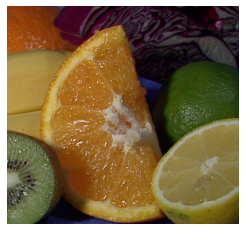

In [5]:
image = image_origin

show_images([image.numpy()])

## データの水増しの手法

### Horizontal Flip

- 水平方向（左右）反転処理
- TensorFlow/Keras APIの`tf.image.random_flip_left_right`を用いる
- 反転するか否かはランダム調整

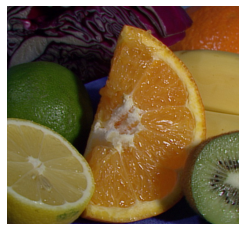

In [6]:
image = image_origin
image = tf.image.random_flip_left_right(image, seed=123)

show_images([image.numpy()])

### Vertical Flip

- 垂直方向（上下）反転処理
- TensorFlow/Keras APIの`tf.image.random_flip_up_down`を用いる
- 反転するか否かはランダム調整

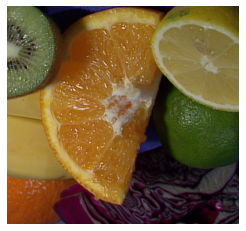

In [7]:
image = image_origin
image = tf.image.random_flip_up_down(image, seed=123)

show_images([image.numpy()])

### Crop

- あるサイズを画像中からランダムに切り出す処理
- TensorFlow/Keras APIの`tf.image.random_crop`を用いる
- 引数`size`で、切り出す画像のサイズを指定

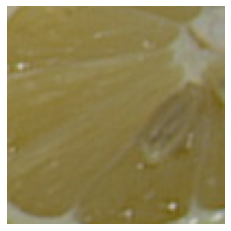

In [8]:
image = image_origin
image = tf.image.random_crop(image, size=(100, 100, 3), seed=123)

show_images([image.numpy()])

### Contrast

- コントラストをランダムに調整する処理
- TensorFlow/Keras APIの`tf.image.random_contrast`を用いる
- 引数`lower`と`upper`で、コントラストの強弱の下限値と上限値を指定

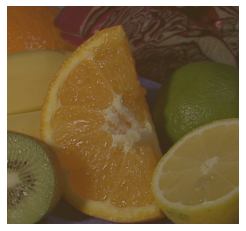

In [9]:
image = image_origin
image = tf.image.random_contrast(image, lower=0.4, upper=0.6)

show_images([image.numpy()])

### Brightness

- 輝度値$\delta$をランダムに調整する処理
- TensorFlow/Keras APIの`tf.image.random_brightness`を用いる
- `-max_delta`$\leq \delta <$`max_delta`

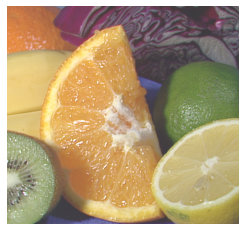

In [10]:
image = image_origin
image = tf.image.random_brightness(image, max_delta=0.8)

show_images([image.numpy()])

### Hue

- 色相$\delta$をランダムに調整する処理
- TensorFlow/Keras APIの`tf.image.random_hue`を用いる
- `-max_delta`$\leq \delta <$`max_delta`

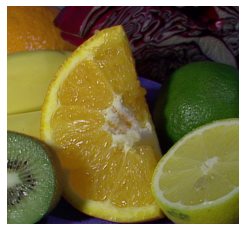

In [11]:
image = image_origin
image = tf.image.random_hue(image, max_delta=0.1)

show_images([image.numpy()])

### Rotate

- 回転処理
- TensorFlow/Keras APIには、90度単位で回転させる`tf.image.rot90`と、角度限定なしの`tf.keras.preprocessing.image.random_rotation`がある
- `tf.image.rot90`
  - 引数`k`$\times 90^\circ$で反時計回りに回転
- `tf.keras.preprocessing.image.random_rotation`
  - 引数`rg`で回転範囲を指定
  - 回転角度はランダム調整

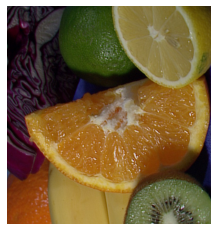

In [12]:
image = image_origin
image = tf.image.rot90(image, k=1)

show_images([image.numpy()])

# image = image_origin
# array = tf.keras.preprocessing.image.img_to_array(image) 
# array = tf.keras.preprocessing.image.random_rotation(array, rg=360, row_axis=0, col_axis=1, channel_axis=2)
# image = tf.keras.preprocessing.image.array_to_img(array)

# show_images([image])

### 補足: その他の手法

#### Random Erasing

- 水増し手法: 大きさがランダムの矩形領域で画像をマスクさせる
- [参考資料: "Random Erasing Data Augmentation"](https://arxiv.org/abs/1708.04896)

<fig><small>出典: https://arxiv.org/pdf/1708.04896v1.pdf</small>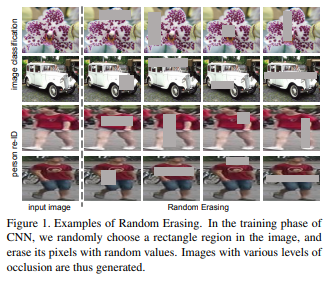</fig>

論文で示された方法で実装。

In [13]:
def random_erasing(img, prob = 0.5, sl = 0.02, sh = 0.4, r1 = 0.2, r2 = 0.8):
    if np.random.random() < prob:
        return img
    else:
        H = img.shape[0]
        W = img.shape[1]
        S = H * W
        while True:
            S_e = S * np.random.uniform(low=sl, high=sh)
            r_e = np.random.uniform(low=r1, high=r2)

            H_e = np.sqrt(S_e * r_e)
            W_e = np.sqrt(S_e / r_e)

            x_e = np.random.randint(0, W)
            y_e = np.random.randint(0, H)

            if x_e + W_e <= W and y_e + H_e <= H:
                img_modified = np.copy(img)
                img_modified[y_e:int(y_e + H_e + 1), x_e:int(x_e + W_e + 1), :] = np.random.uniform(0, 1)
                return img_modified

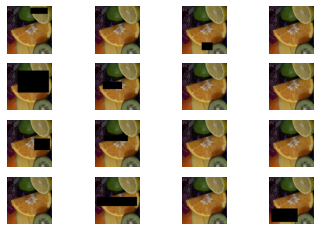

In [14]:
show_images([
             random_erasing(image.numpy()),
             random_erasing(image.numpy()),
             random_erasing(image.numpy()),
             random_erasing(image.numpy()),
             random_erasing(image.numpy()),
             random_erasing(image.numpy()),
             random_erasing(image.numpy()),
             random_erasing(image.numpy()),
             random_erasing(image.numpy()),
             random_erasing(image.numpy()),
             random_erasing(image.numpy()),
             random_erasing(image.numpy()),
             random_erasing(image.numpy()),
             random_erasing(image.numpy()),
             random_erasing(image.numpy()),
             random_erasing(image.numpy()),
             ])

#### MixUp

- 水増し手法: 2つの学習データを混合（ラベル/データ双方を線形補完）させる
- [参考資料: "mixup: Beyond Empirical Risk Minimization"](https://arxiv.org/abs/1710.09412)

<fig><small>出典: https://arxiv.org/pdf/1710.09412v1.pdf</small>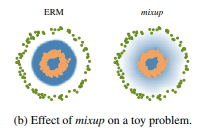</fig>

ここでは、`mnist`のデータセットを用いて、MixUpを確認します。

MixUpでは、データセット中の2つの画像･ラベルを混合することで実現します。

そのためここでは、`mnist`データセットで10枚分ずらして取得したデータセットを混合することでMixUpの動作を確認することにします。

MixUpでは、ベータ分布に基づく分布から取得した割合で、2つの入力データとラベルを混合します。
次の関数は、ベータ分布に基づくサンプリングを行い、混合割合を取得するためのコードです。

In [15]:
def sample_beta_distribution(size, concentration_0, concentration_1):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

次の関数では、実際に2つのデータセットの入力データ、ラベルデータを混合します。

前で定義した、`sample_beta_distribution`を使用して混合割合を取得しています。

In [16]:
def mix_up(ds_one, ds_two, alpha=0.4):
    # ds_oneとds_twoは10枚分ずれたmnistのデータセット。
    # どちらのデータセットにも入力データの画像とラベルが含まれている。
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two

    # この後の処理で必要なため、データセットのバッチサイズを取得
    batch_size = tf.shape(images_one)[0]

    # 上で定義したベータ分布に基づくサンプリングで、バッチサイズ分の混合割合を取得。
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # 2つのデータセットを混合割合に基づいて、入力データ･ラベルの両方を混合する。
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

ここまでに定義したMixUpの関数を用いて、`mnist`のデータセットで混合の様子を確認します。

11501568/11490434 [==============================] - 0s 0us/step
ラベル:  [0.0, 0.0, 0.0, 0.1511220932006836, 0.0, 0.8488779067993164, 0.0, 0.0, 0.0, 0.0]
ラベル:  [0.06839152425527573, 0.0, 0.0, 0.0, 0.0, 0.9316084980964661, 0.0, 0.0, 0.0, 0.0]
ラベル:  [0.0, 0.0, 0.0, 0.0011475682258605957, 0.9988524317741394, 0.0, 0.0, 0.0, 0.0, 0.0]
ラベル:  [0.0, 0.0013670886401087046, 0.0, 0.0, 0.0, 0.0, 0.9986329078674316, 0.0, 0.0, 0.0]
ラベル:  [0.0, 0.26591920852661133, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7340807914733887]
ラベル:  [0.0, 0.0, 0.15536369383335114, 0.0, 0.0, 0.0, 0.0, 0.8446363210678101, 0.0, 0.0]
ラベル:  [0.0, 0.7048753499984741, 0.2951246500015259, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ラベル:  [0.0, 0.0, 0.0, 0.9470276236534119, 0.0, 0.0, 0.0, 0.0, 0.052972376346588135, 0.0]
ラベル:  [0.0, 0.009643902070820332, 0.0, 0.0, 0.0, 0.0, 0.9903560876846313, 0.0, 0.0, 0.0]


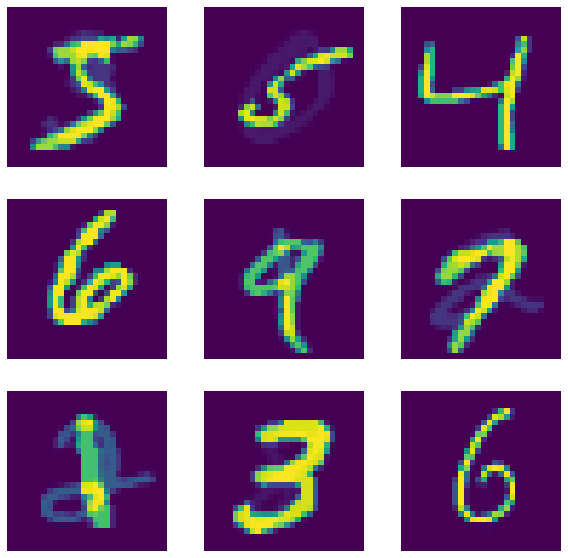

In [17]:
# mnistデータセットの読み込み
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# データを正規化し、28x28の画像の形状に変形する。
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

# ラベルをone-hotラベルの形式に変形する
y_train = tf.one_hot(y_train, 10)

# 10枚分ずれたデータセットを取得する。
# 1つ目のデータセットは、0枚目からmnistの最後から10こ手前まで。
# 2つ目のデータセットは、10枚目からmnistの最後まで。
# また、16枚でミニバッチを構成する
BATCH_SIZE = 16
train_ds_one = (tf.data.Dataset.from_tensor_slices((x_train[:-10], y_train[:-10])).batch(BATCH_SIZE))
train_ds_two = (tf.data.Dataset.from_tensor_slices((x_train[10:], y_train[10:])).batch(BATCH_SIZE))

# 10枚ずれたデータセット同士を連結し、MixUpの組合せを作る。
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

# 先に定義したMixUpの関数を使って、2つのデータセットを処理する。
train_ds_mu = train_ds.map(lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.4))

# MixUpされた9枚の画像を表示する。
# One-hot表現されたラベルも混合されていることがわかる。
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print('ラベル: ', label.numpy().tolist())
    plt.axis("off")

## 複数の手法の組み合わせ

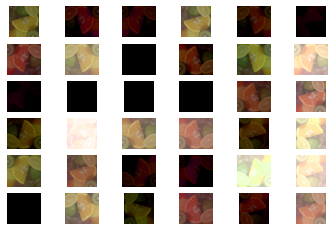

In [18]:
def data_augmentation(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, lower=0.4, upper=0.6)
    image = tf.image.random_brightness(image, max_delta=0.8)
    image = tf.image.rot90(image, k=random.choice((0, 1, 2)))
    image = tf.image.random_hue(image, max_delta=0.1)
    return image

image = image_origin

show_images([data_augmentation(image).numpy() for _ in range(36)])